In [1]:
# *** Allow printing for each command in Jupyter cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# General
import pandas as pd 
import numpy as np # linear algebra
import seaborn as sns # plotting
import matplotlib.pyplot as plt # plotting
%matplotlib inline
import os # accessing directory structure

# NLP
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
import re
import spacy

####Lemmatization
from nltk.stem import WordNetLemmatizer
# Lemmatize with POS Tag
from nltk.corpus import wordnet

In [3]:
# data/TABSA_dataset/all-data.csv
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')
# pip install lxml

In [17]:
def get_aspectTerms_or_aspectCategories(terms_or_categories):
    
    if terms_or_categories.tag == 'aspectTerms':
        terms = terms_or_categories
        if len(terms.getchildren()) > 0 :
            return terms.tag, [term.attrib for term in terms.getchildren()]
        else :
            return terms.tag, None
        
    if terms_or_categories.tag == 'aspectCategories':        
        cats = terms_or_categories
        if len(cats.getchildren()) > 0 :
            return cats.tag, [cat.attrib for cat in cats.getchildren()]
        else :
            return  cats.tag, None
    

### Read XML file and parse

In [34]:
from lxml import objectify

xml_data = objectify.parse('data/ABSA_Gold_TrainData/Restaurants_Train.xml')  # Parse XML data
root = xml_data.getroot()  # Root element
sentences = root.getchildren()

# Check the first sentence element
sentences[1].tag
sent_id = sentences[1].attrib['id'] 
sent_text = sentences[1].getchildren()[0]
if len(sentences[1].getchildren()) > 1:
    _type, _items = get_aspectTerms_or_aspectCategories(sentences[1].getchildren()[1])
    print (_type, _items, sep = ' : ')
if len(sentences[1].getchildren()) > 2:
    _type, _items = get_aspectTerms_or_aspectCategories(sentences[1].getchildren()[2])
    print (_type, _items, sep = ' : ')   
        

'sentence'

aspectTerms : [{'term': 'food', 'polarity': 'positive', 'from': '57', 'to': '61'}]
aspectCategories : [{'category': 'food', 'polarity': 'positive'}, {'category': 'anecdotes/miscellaneous', 'polarity': 'negative'}]


In [22]:
dictinary_list = []
for sentence in sentences[0:]:
    assert sentence.tag == 'sentence'
    sent_id = sentence.attrib['id'] 
    sent_text = sentence.getchildren()[0]

    if len(sentence.getchildren()) > 1:
        _type_1, _items_1 = get_aspectTerms_or_aspectCategories(sentence.getchildren()[1])        
            
    if len(sentence.getchildren()) > 2:
        _type_2, _items_2 = get_aspectTerms_or_aspectCategories(sentence.getchildren()[2])
        
    if _type_1 == 'aspectTerms' and _type_2 == 'aspectCategories' :
        aspectTerms = _items_1
        aspectCategories = _items_2
    else:
        aspectTerms = _items_2
        aspectCategories = _items_1
    
    dictionary_data = {'Sentence_Id': sent_id, 
                        'Texts': str(sent_text), 
                        'AspectTerms': str(aspectTerms), 
                        'AspectCategories': str(aspectCategories)
                      }
    dictinary_list.append(dictionary_data)
    
    # print (sent_id, sent_text, aspectTerms, aspectCategories, sep='\n')
    # print()
    
data_df = pd.DataFrame.from_dict(dictinary_list)
data_df.head()

,Sentence_Id,Texts,AspectTerms,AspectCategories
0,3121,But the staff was so horrible to us.,"[{'term': 'staff', 'polarity': 'negative', 'fr...","[{'category': 'service', 'polarity': 'negative'}]"
1,2777,"To be completely fair, the only redeeming fact...","[{'term': 'food', 'polarity': 'positive', 'fro...","[{'category': 'food', 'polarity': 'positive'},..."
2,1634,"The food is uniformly exceptional, with a very...","[{'term': 'food', 'polarity': 'positive', 'fro...","[{'category': 'food', 'polarity': 'positive'}]"
3,2534,Where Gabriela personaly greets you and recomm...,"[{'category': 'food', 'polarity': 'positive'}]","[{'category': 'service', 'polarity': 'positive'}]"
4,583,"For those that go once and don't enjoy it, all...","[{'category': 'food', 'polarity': 'positive'}]","[{'category': 'anecdotes/miscellaneous', 'pola..."


In [24]:
# data_df.columns = ['Senti', 'Texts']

with pd.option_context('display.max_colwidth', -1):     
    display(data_df['Texts'][0:10])


0    But the staff was so horrible to us.                                                                                                                           
1    To be completely fair, the only redeeming factor was the food, which was above average, but couldn't make up for all the other deficiencies of Teodora.        
2    The food is uniformly exceptional, with a very capable kitchen which will proudly whip up whatever you feel like eating, whether it's on the menu or not.      
3    Where Gabriela personaly greets you and recommends you what to eat.                                                                                            
4    For those that go once and don't enjoy it, all I can say is that they just don't get it.                                                                       
5    Not only was the food outstanding, but the little 'perks' were great.                                                                                          
6    It is

### Find out the top 100 words which are getting used in the text of the data

In [25]:
top_N = 100 #top 100 words

#convert list of list into text
a = data_df['Texts'].str.lower().str.cat(sep=' ')

# removes punctuation,numbers and returns list of words
b = re.sub('[^A-Za-z]+', ' ', a)

In [26]:
#remove all the stopwords from the text
stop_words = list(get_stop_words('en'))         
nltk_words = list(stopwords.words('english'))   
stop_words.extend(nltk_words)

In [27]:
word_tokens = word_tokenize(b) # Tokenization
filtered_sentence = [w for w in word_tokens if not w in stop_words]
filtered_sentence = []
for w in word_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)

In [28]:
# Remove characters which have length less than 2  
without_single_chr = [word for word in filtered_sentence if len(word) > 2]

# Remove numbers
cleaned_data_title = [word for word in without_single_chr if not word.isnumeric()]

### Lemmatization
I am using Wordnet Lemmatizer with appropriate POS tag.
Function to map word with its POS tag

In [29]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# 1. Init Lemmatizer
lemmatizer = WordNetLemmatizer()

In [30]:
lemmatized_output = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in cleaned_data_title]
lemmatized_output = [word for word in lemmatized_output if not word.isnumeric()]


### Frequency distribution 

In [31]:
word_dist = nltk.FreqDist(lemmatized_output)
top100_words = pd.DataFrame(word_dist.most_common(top_N), columns=['Word', 'Frequency'])

<Figure size 360x360 with 0 Axes>

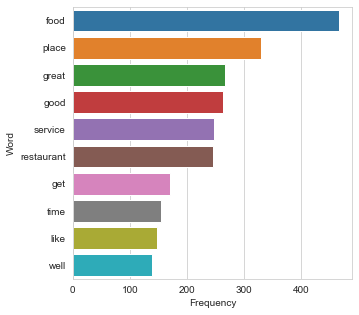

In [32]:
plt.figure(figsize=(5,5))
sns.set_style("whitegrid")
ax = sns.barplot(x="Frequency",y="Word", data=top100_words.head(10))

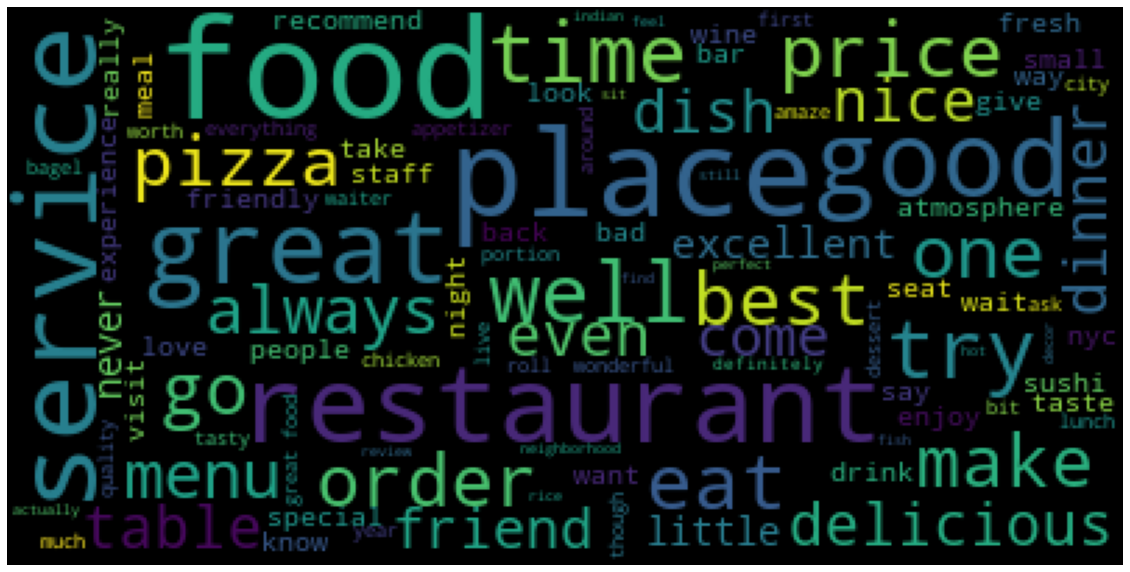

In [33]:
def wc(data,bgcolor,title):
    plt.figure(figsize = (20,20))
    wc = WordCloud(background_color = bgcolor, max_words = 100,  max_font_size = 50)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')

wc(lemmatized_output,'black','Common Words' )